# Nearest neighbour classifier

A common classification algorithm is a k-nearest neighbours classifier. This calculates distances between points in the parameter space of the input features. It find the nearest 5 point in the training set, looks at the value of the target feature for each of them and assign a class to the new point based on which class is most represented in the neighbour points. This approach may work less well for something the like the XBT dataset, where distance in parameter space is not very nicely defined.

In [1]:
import os
import sys
from pathlib import Path
import functools

import pandas
import numpy

import matplotlib
import matplotlib.pyplot
import warnings
warnings.filterwarnings('ignore')

In [2]:
import ipywidgets
import time

In [3]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.neighbors
import sklearn.metrics

In [4]:
root_repo_dir = Path().absolute().parent
sys.path = [os.path.join(root_repo_dir,'dataexploration'),
            os.path.join(root_repo_dir,'classification'),
            os.path.join(root_repo_dir,'preprocessing'),
            os.path.join(root_repo_dir,'metrics'),
           ] + sys.path

In [5]:
from xbt_dataset import XbtDataset, UNKNOWN_STR, cat_output_formatter

In [6]:
from imeta import imeta_classification, XBT_MAX_DEPTH

In [7]:
# Set up some site specific parameters for the notebook
environment = 'pangeo'
env_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/csv_with_imeta',
    'pangeo': '/data/misc/xbt-data/csv_with_imeta/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}
output_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/csv_output',
    'pangeo': '/data/misc/xbt-data/csv_output/',

}
result_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/results',
    'pangeo': '/data/misc/xbt-data/results/',
}


In [8]:
output_dir = output_dirs[environment]
output_fname_template = 'xbt_output_{classifier}_{suffix}.csv'
result_dir = result_dirs[environment]
result_fname_template = 'xbt_metrics_{classifier}_{suffix}.csv'

In [22]:
cv_metric_names = ['f1_weighted','precision_weighted','recall_weighted']
input_feature_names = ['country','max_depth', 'year', 'lat', 'lon']

In [10]:
classifier_class = sklearn.neighbors.KNeighborsClassifier
classifier_opts = {'n_neighbors':5}
classifier_name = 'nearest_neighbours5'
suffix='latLon_country'

In [11]:
%%time
xbt_full_dataset = XbtDataset(env_data_dirs[environment], env_date_ranges[environment])

CPU times: user 1min 43s, sys: 9.77 s, total: 1min 52s
Wall time: 3min 57s


## Data preparation

Data preparation is as with the standard imeta decision tree approach. We are using country and lat/long coordinate in this notebook as this seems to give better performance.

In [12]:
%%time
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})

CPU times: user 272 ms, sys: 36.1 ms, total: 309 ms
Wall time: 306 ms


In [13]:
_ = xbt_labelled.get_ml_dataset(return_data = False)

In [14]:
%%time
unseen_cruise_numbers = xbt_labelled.sample_feature_values('cruise_number', fraction=0.1)

CPU times: user 30.4 ms, sys: 248 µs, total: 30.6 ms
Wall time: 28.8 ms


In [15]:
%%time
xbt_unseen = xbt_labelled.filter_obs({'cruise_number': unseen_cruise_numbers}, mode='include', check_type='in_filter_set')
xbt_working = xbt_labelled.filter_obs({'cruise_number': unseen_cruise_numbers}, mode='exclude', check_type='in_filter_set')

CPU times: user 7.48 s, sys: 0 ns, total: 7.48 s
Wall time: 7.48 s


In [16]:
%%time
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)

CPU times: user 2min 52s, sys: 577 ms, total: 2min 53s
Wall time: 2min 53s


In [17]:
imeta_model = imeta_classes.apply(lambda t1: t1[0])
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1])
imeta_instrument = imeta_classes.apply(lambda t1: f'XBT: {t1[0]} ({t1[1]})') 

We are currently training and evaulating separately for model and manufacturer. We will also need to train and evaulate together as this is ultimately what is wanted (a combined probe model and manufacturer field).

We are using the default 80/20 split in scikit-learn for now. Further work will need to do proper cross validation where several different splits are randomly selected to verify our results are not an artifact of the randomly chosen split.

In [18]:
%%time
sklearn.metrics.recall_score(
    xbt_labelled._feature_encoders['instrument'].transform(pandas.DataFrame(xbt_labelled['instrument'])),
    xbt_labelled._feature_encoders['instrument'].transform(pandas.DataFrame(imeta_instrument)),
    average='micro',
)

CPU times: user 6.26 s, sys: 268 ms, total: 6.53 s
Wall time: 6.52 s


0.7532183867682691

In [19]:
%%time
xbt_train_all, xbt_test_all = xbt_working.train_test_split(refresh=True, features=['instrument', 'year'])

CPU times: user 3min 1s, sys: 45 ms, total: 3min 1s
Wall time: 3min 1s


In [23]:
X_train_all = xbt_train_all.filter_features(input_feature_names).get_ml_dataset()[0]
X_test_all = xbt_test_all.filter_features(input_feature_names).get_ml_dataset()[0]
X_unseen_all = xbt_unseen.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_train_all = xbt_train_all.filter_features(['instrument']).get_ml_dataset()[0]
y_instr_test_all = xbt_test_all.filter_features(['instrument']).get_ml_dataset()[0]
y_instr_unseen_all = xbt_unseen.filter_features(['instrument']).get_ml_dataset()[0]

## Training the classifier

We are using the scikit-learn classifier as the closest analogue to the structure of the iMeta algorithm. This tree can have many more nodes and leaves than iMeta though. it is quick to train and evaluate so it is a useful starting point for setting up the ML processing pipelines, as all the scikit-learn classifiers have a common interface. 

For the model and manufacturer, we train a Decision ree Classifier, then use it to predict values for the train and test sets. We then calculate the accuracy metrics for each for the whole dataset. 

I am using precision, recall and F1 as fairly standard ML metrics of accuracy. Recall is what has been used in the two previous papers (Palmer et. al, Leahy and Llopis et al) so that is the focus. Support is a useful to see what proportion of the profiles in the dataset belong to each of the different classes.

In [24]:
metrics_per_class_all = {}
metrics_avg_all = {}

In [25]:
%%time
clf_dt_instr1 = classifier_class(**classifier_opts)
clf_dt_instr1.fit(X_train_all,y_instr_train_all)

CPU times: user 57.9 s, sys: 421 ms, total: 58.3 s
Wall time: 58.2 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Although training the classifier is quick, inference is slow with nearest neighbour. This is unsurprising as nothing is calculated up front, rather neighbours are found for input feature vector and used to determine the label. So the whole train dataset is used in inference.

In [26]:
y_res_train_instr_all = clf_dt_instr1.predict(X_train_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_train_all, y_res_train_instr_all, )
metrics_per_class_all.update( {
    'precision_instr_train': metrics1[0],
    'recall_instr_train': metrics1[1],
    'f1_instr_train': metrics1[2],
    'support_instr_train': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_train' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_train' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_train' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [27]:
y_res_test_instr_all = clf_dt_instr1.predict(X_test_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_test_all, y_res_test_instr_all, )
metrics_per_class_all.update( {
    'precision_instr_test': metrics1[0],
    'recall_instr_test': metrics1[1],
    'f1_instr_test': metrics1[2],
    'support_instr_test': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_test' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_test' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_test' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [28]:
y_res_unseen_instr_all = clf_dt_instr1.predict(X_unseen_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_unseen_all, y_res_unseen_instr_all, )
metrics_per_class_all.update( {
    'precision_instr_unseen': metrics1[0],
    'recall_instr_unseen': metrics1[1],
    'f1_instr_unseen': metrics1[2],
    'support_instr_unseen': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_unseen' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_unseen' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_unseen' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [29]:
metrics_per_class_all['instrument'] = list(xbt_labelled._feature_encoders['instrument'].categories_[0])

In [30]:
df_metrics_per_class_instr = pandas.DataFrame.from_dict({k1:v1 for k1,v1 in metrics_per_class_all.items() if 'instr' in k1})

In [31]:
df_metrics_avg = pandas.DataFrame.from_dict({
    'target': ['instrument_train','instrument_test', 'instrument_unseen'],
    'precision': [v1 for k1,v1 in metrics_avg_all.items() if 'precision' in k1],
    'recall': [v1 for k1,v1 in metrics_avg_all.items() if 'recall' in k1],
    'f1': [v1 for k1,v1 in metrics_avg_all.items() if 'f1' in k1],
})

In [32]:
df_metrics_avg

,target,precision,recall,f1
0,instrument_train,0.975191,0.971779,0.973361
1,instrument_test,0.964404,0.960709,0.962396
2,instrument_unseen,0.911741,0.907280,0.908250


# Classification result plots

The plots below show the results for the whole XBT dataset. Compared to the decision tree dataset, the algorithm does a bit better for examples where there are very few example profiles in the training set, but not 

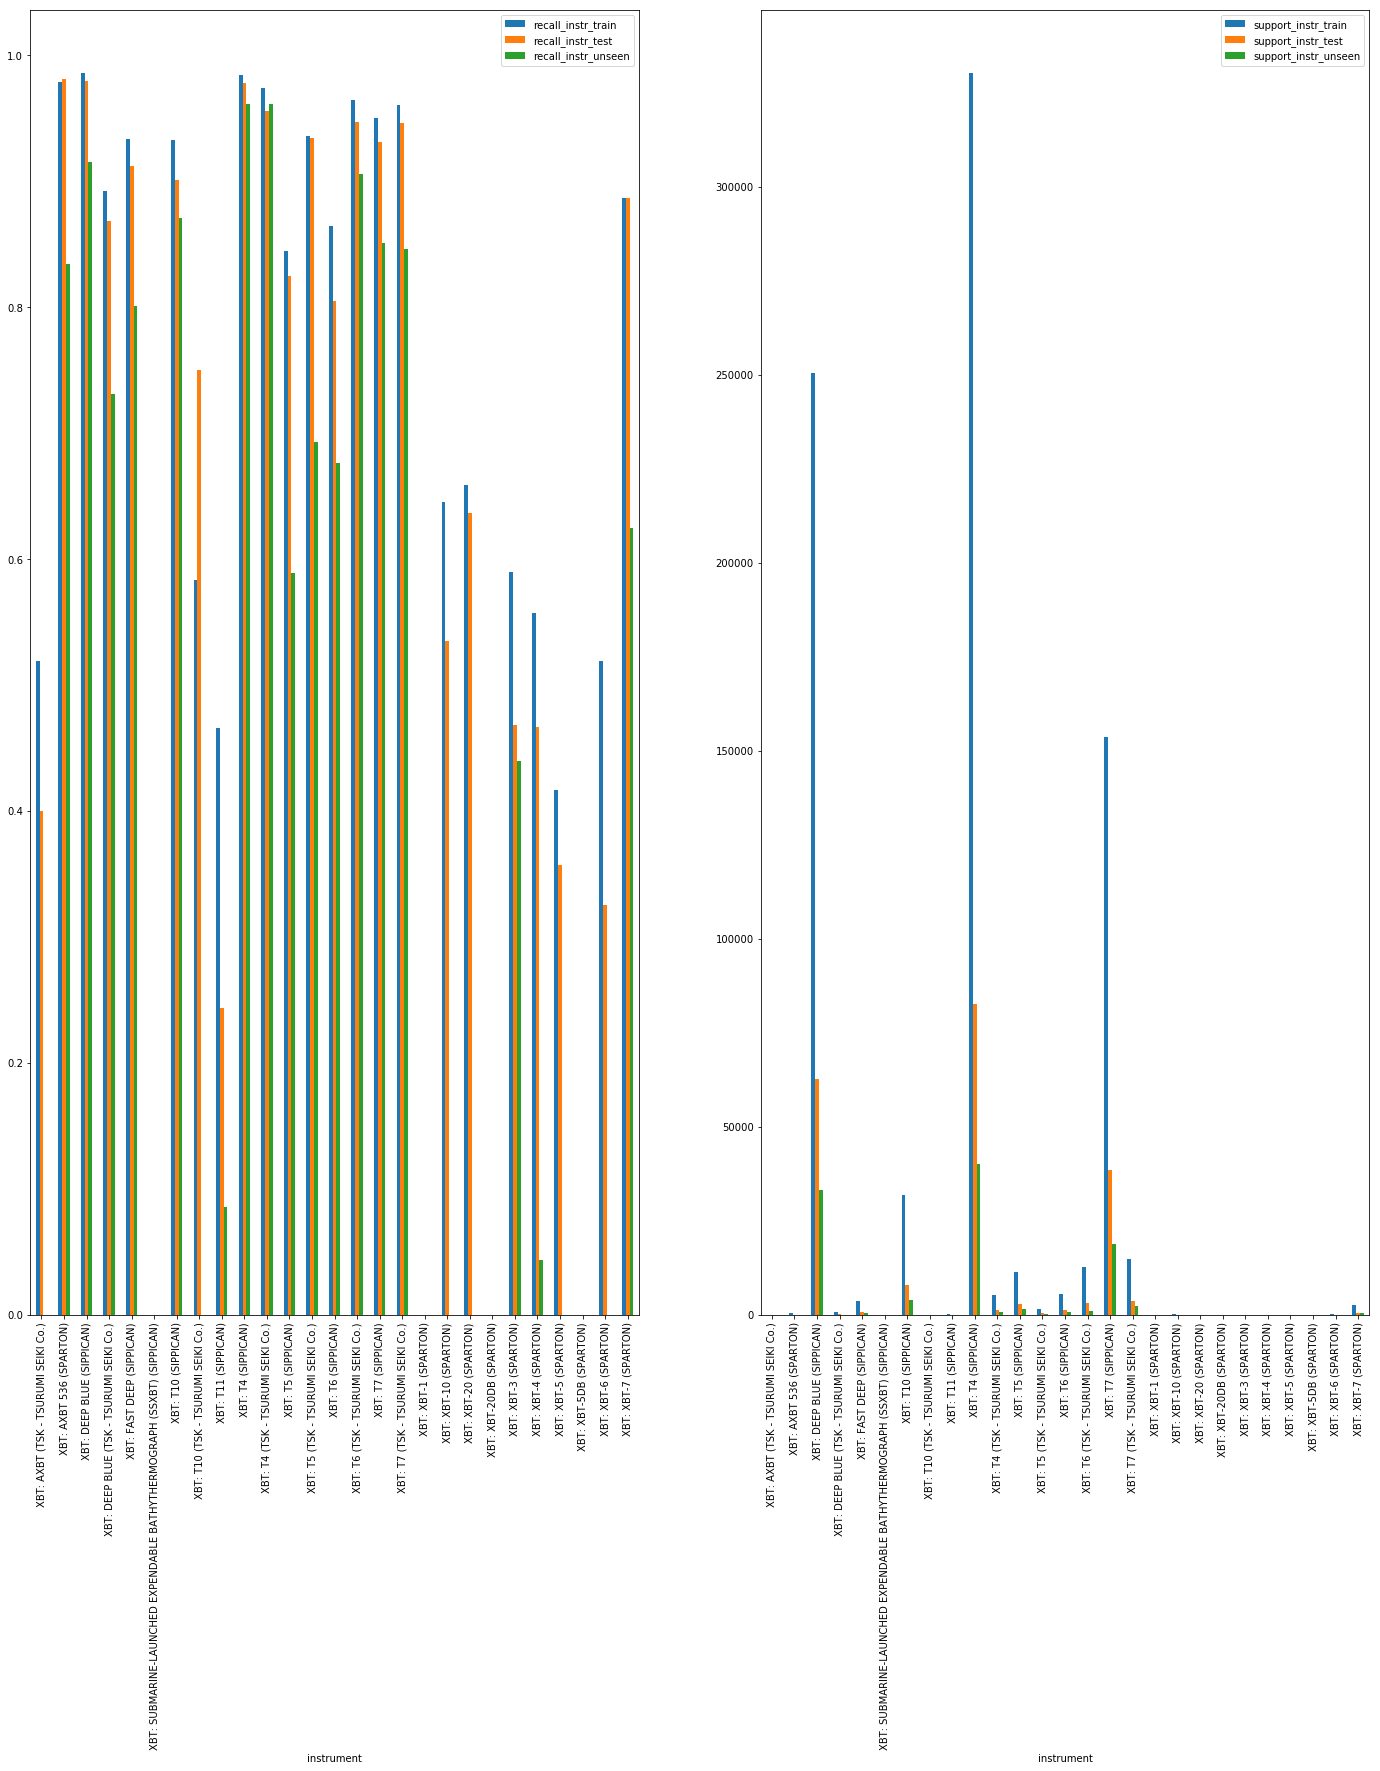

In [34]:
fig_results_all_dt = matplotlib.pyplot.figure('xbt_results_all_dt', figsize=(24,24))
axis_instr_metrics = fig_results_all_dt.add_subplot(121)
_ = df_metrics_per_class_instr.plot.bar(x='instrument', y=['recall_instr_train','recall_instr_test','recall_instr_unseen'],ax=axis_instr_metrics)
axis_instr_support = fig_results_all_dt.add_subplot(122)
_ = df_metrics_per_class_instr.plot.bar(x='instrument',y=['support_instr_train', 'support_instr_test', 'support_instr_unseen'], ax=axis_instr_support)


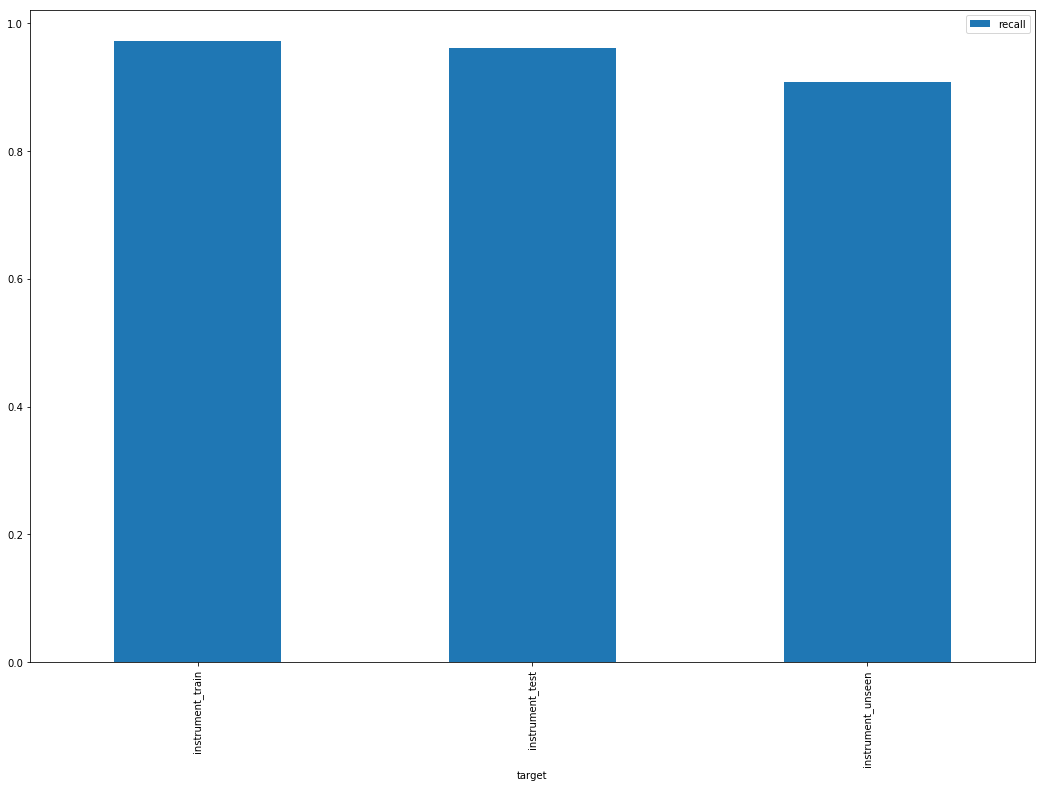

In [35]:
df_metrics_avg.plot.bar(figsize=(18,12), x='target', y='recall')

## Classification results

The contents of the XBT dataset varies over the time period, so previous papers have looked at classification accuracy (recall) year by year to evaluate how performance varies with different distribution of probe types.

To do this we apply the classifier to the train and test data for each year separetly and calculate the metrics year by year.

In [36]:
def score_year(xbt_df, year, clf, input_features, target_feature):
    X_year = xbt_df.filter_obs({'year': year}, ).filter_features(input_features).get_ml_dataset()[0]
    y_year = xbt_df.filter_obs({'year': year} ).filter_features([target_feature]).get_ml_dataset()[0]
    y_res_year = clf.predict(X_year)
    metric_year = sklearn.metrics.precision_recall_fscore_support(
        y_year, y_res_year, average='micro')
    return metric_year

In [37]:
eval_progress = ipywidgets.IntProgress(min=env_date_ranges[environment][0],
                                           max= env_date_ranges[environment][1],
                                          description='Evaluating',
                                          bar_style='info')
eval_progress

IntProgress(value=1966, bar_style='info', description='Evaluating', max=2015, min=1966)

In [38]:
results_by_year = {}

In [39]:
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    results_by_year[year] = {
        'metric_train_instr' : score_year(xbt_train_all, year, clf_dt_instr1, input_feature_names, 'instrument'),
        'metric_test_instr' : score_year(xbt_test_all, year, clf_dt_instr1, input_feature_names, 'instrument'),
        'metric_unseen_instr' : score_year(xbt_unseen, year, clf_dt_instr1, input_feature_names, 'instrument'),
    }
    eval_progress.value = year


In [40]:
recall_by_year = pandas.DataFrame.from_dict({ 
    'year':  list(results_by_year.keys()),
    'recall_train_instr' : [m1['metric_train_instr'][1] for y1,m1 in results_by_year.items()],
    'recall_test_instr' : [m1['metric_test_instr'][1] for y1,m1 in results_by_year.items()],
    'recall_unseen_instr' : [m1['metric_unseen_instr'][1] for y1,m1 in results_by_year.items()],
})


In [41]:
instr_encoder = xbt_labelled._feature_encoders['instrument']

In [42]:
eval_progress.value = env_date_ranges[environment][0]
imeta_results = []
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    y_imeta_instr = instr_encoder.transform(pandas.DataFrame(imeta_instrument[xbt_labelled.xbt_df.year == year]))
    xbt_instr1 = instr_encoder.transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].instrument))
    
    
    (im_pr_instr, im_rec_instr, im_f1_instr, im_sup_instr) = sklearn.metrics.precision_recall_fscore_support(xbt_instr1, y_imeta_instr,average='micro')

    imeta_results += [{'year': year,
                       'imeta_instr_recall': im_rec_instr,
                       'imeta_instr_precision': im_pr_instr,
                      }]
    eval_progress.value = year

In [43]:
imeta_res_df = pandas.DataFrame.from_records(imeta_results)

In [44]:
results_df = pandas.merge(recall_by_year, imeta_res_df).merge(
    pandas.DataFrame.from_dict({
        'year': xbt_labelled['year'].value_counts(sort=False).index,
        'num_samples': xbt_labelled['year'].value_counts(sort=False).values,
    }))

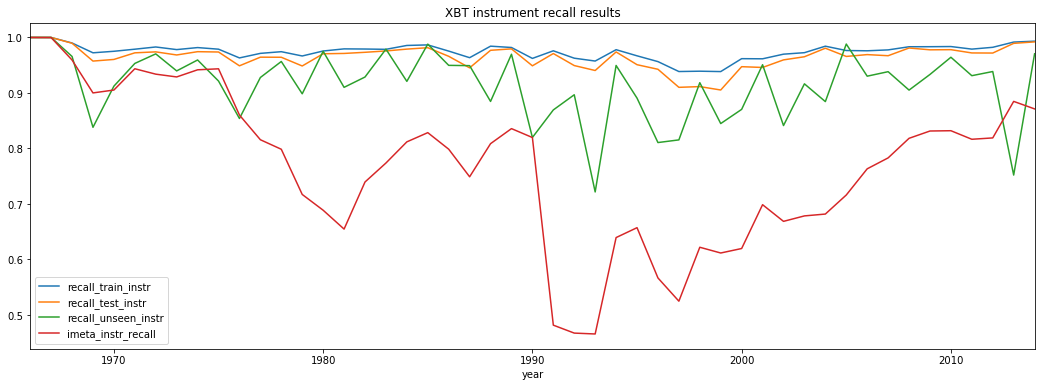

In [45]:
fig_model_recall_results = matplotlib.pyplot.figure('xbt_model_recall', figsize=(18,6))
ax_instr_recall_results = fig_model_recall_results.add_subplot(111, title='XBT instrument recall results')
_ = results_df.plot.line(x='year',y=['recall_train_instr','recall_test_instr', 'recall_unseen_instr', 'imeta_instr_recall'], ax=ax_instr_recall_results)

Results are broadly similar to the standard ML decision tree results. The train metrics are slightly lower, but the test metrics are slightly better. Unfortunately results are similarly degraded for the unseen set compared to the test set.

In [46]:
results_df['improvement_instr'] = results_df.apply(lambda r1: ((r1['recall_test_instr'] /  r1['imeta_instr_recall'])-1)*100.0 , axis=1)

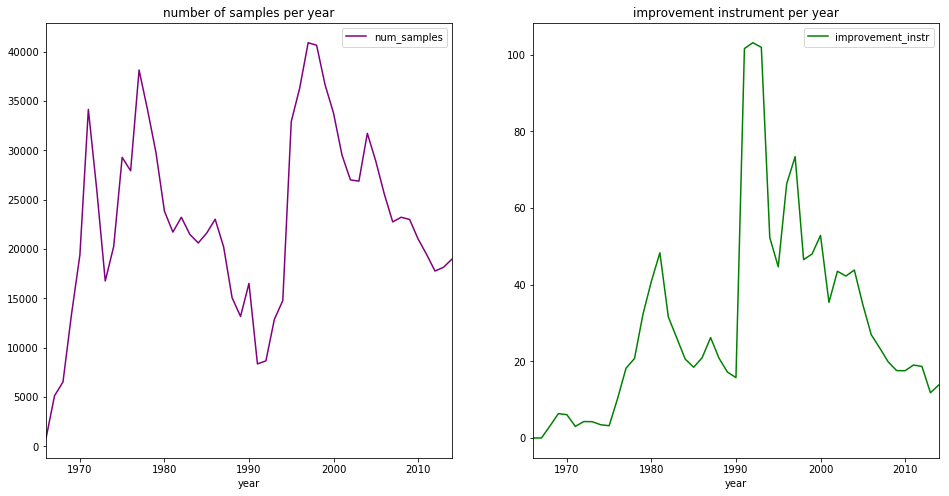

In [47]:
fig_num_samples_per_year = matplotlib.pyplot.figure('fig_num_samples_per_year', figsize=(16,8))
ax_num_samples = fig_num_samples_per_year.add_subplot(121, title='number of samples per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['num_samples'],c='purple' )
ax_instr_improve = fig_num_samples_per_year.add_subplot(122, title='improvement instrument per year')
_ = results_df.plot.line(ax=ax_instr_improve, x='year',y=['improvement_instr'], c='green' )


In [48]:
results_df.to_csv(os.path.join(result_dir,result_fname_template.format(classifier=classifier_name,
                                                                       suffix=suffix)))

### Outputing the data

To filter based on what profiles we can use for predicting, we need some way of checking each profile we create these checkers from the labelled dataset, because the subset of data that was used for training determines what subset is valid for prediction. For example, if a country is not present in the training data, then the prediction function won't be able to handle that profile to predict a probe model and manufacturer. Profiles that are not handled by the trained classifier will get the label "UNKNOWN".


In [49]:
# checker functions check each element of the profile metadata that could be a problem. The checkers are constructed from the labelled data subset.
checkers_labelled = {f1: c1 for f1, c1 in xbt_labelled.get_checkers().items() if f1 in input_feature_names}

In [50]:
result_feature_name = 'instrument_res_dt'

In [51]:
%%time
xbt_predictable = xbt_full_dataset.filter_predictable(checkers_labelled)

CPU times: user 3min 57s, sys: 998 ms, total: 3min 58s
Wall time: 3min 58s


In [52]:
res_ml1 = clf_dt_instr1.predict(xbt_predictable.filter_features(input_feature_names).get_ml_dataset()[0])
res2 = list(xbt_labelled._feature_encoders['instrument'].inverse_transform(res_ml1).reshape(-1))

In [53]:
xbt_predictable.xbt_df[result_feature_name] = res2

In [54]:
xbt_full_dataset.merge_features(xbt_predictable, [result_feature_name],
                               fill_values = {result_feature_name: UNKNOWN_STR},
                               encoders={result_feature_name: xbt_labelled._feature_encoders['instrument']},
                               output_formatters={result_feature_name: cat_output_formatter})

In [55]:
%%time
xbt_full_dataset.output_data(os.path.join(output_dir, output_fname_template.format(classifier=classifier_name,
                                                                                  suffix=suffix)),
                             add_ml_features=[result_feature_name])

CPU times: user 1min 38s, sys: 1.37 s, total: 1min 39s
Wall time: 1min 49s


### Summary

Nearest neigbhour does seem to have some advantage for underepresented classes. Ultimately we intend creating an ensemble of classifiers to create a vote based pseudo-probability of a particular being the correct probe type, and nearest neighbour would be a helpful member of this ensemble. Slowness of inference would be one reason not to include. We should consider what other classifier options have similar advantages for under-represented classes, but with better inference performance.